NMF (Non-Negative Matrix Factorization)

In [58]:
!pip install gensim

import sys
import re, numpy as np, pandas as pd
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# NLTK Stop words
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = STOP_WORDS
stop_words.update(['from', 'subject', 're', 'edu','etl', 'use','floor','debonair','instal','not','spite','wall','paint','event','prop','count','bed', 'pillow','would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even','train' ,'right', 'line', 'even', 'featurecasual','also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


In [59]:
# Import Dataset
df = pd.read_excel("/content/Company_Data__.xlsx")
print(df.shape)
df.head()


(82, 3)


Company names                                               Text  \
0                A&G  "Safety & Compliance Our Strengths are: Pinaki...   
1           AKH echo  "CSR Approaches Towards Sustainable Industry I...   
2          Akij jute  "Bright & meritorious Students Scholarship pro...   
3      Alphaclothing  Corporate Social Responsibility At Alpha Cloth...   
4  Aman text limited  CSR – Aman Group Ltd +8809612613000info@amangr...   

       CertLevel  
0  Not Certified  
1           Gold  
2  Not Certified  
3           Gold  
4       Platinum

In [60]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

# Convert to list
data = df.Text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

<>:3: SyntaxWarning:

invalid escape sequence '\S'

<>:4: SyntaxWarning:

invalid escape sequence '\s'

<>:3: SyntaxWarning:

invalid escape sequence '\S'

<>:4: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipython-input-4049406598.py:3: SyntaxWarning:

invalid escape sequence '\S'

/tmp/ipython-input-4049406598.py:4: SyntaxWarning:

invalid escape sequence '\s'



[['safety', 'compliance', 'our', 'strengths', 'are', 'pinaki', 'is', 'compliant', 'manufacturing', 'company', 'fire', 'exits', 'and', 'sufficient', 'fire', 'protection', 'are', 'in', 'place', 'on', 'each', 'floor', 'all', 'workers', 'are', 'over', 'years', 'minimum', 'wages', 'are', 'guaranteed', 'for', 'all', 'workers', 'no', 'forced', 'labour', 'overtime', 'is', 'voluntary', 'no', 'women', 'are', 'deployed', 'in', 'the', 'use', 'of', 'heavy', 'machinery', 'first', 'aid', 'facilities', 'are', 'available', 'in', 'each', 'department', 'the', 'factory', 'premises', 'are', 'smoking', 'free', 'each', 'floor', 'is', 'well', 'ventilated', 'boilers', 'and', 'generator', 'are', 'conveniently', 'located', 'in', 'safe', 'zones', 'in', 'the', 'factory', 'area', 'pure', 'drinking', 'water', 'supply', 'is', 'available', 'upkeep', 'of', 'proper', 'methods', 'for', 'materials', 'safety', 'are', 'in', 'place', 'regularly', 'maintained', 'automatic', 'fire', 'detection', 'systems', 'exist', 'fire', 'do

In [61]:


# Build the bigram and trigram models
bigram = Phrases(data_words, min_count=5, threshold=100)  # higher threshold means fewer phrases
trigram = Phrases(bigram[data_words], threshold=100)

# Construct Phraser models
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)


In [62]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams, Lemmatization and remove Proper Nouns"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.pos_ != 'PROPN'])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    return texts_out


data_ready = process_words(data_words)

In [63]:
# Join the preprocessed words into a single string for each document
processed_texts = [" ".join(text) for text in data_ready]

# Initialize TfidfVectorizer without additional stop words since they are already removed
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 1))

# Transform the preprocessed text data into a TF-IDF matrix
tfidf = tfidf_vectorizer.fit_transform(processed_texts)



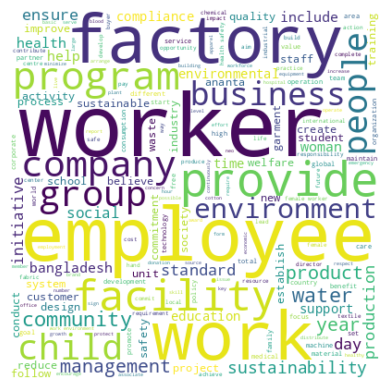

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_texts = ' '.join(processed_texts)

wordcloud = WordCloud(background_color='white', max_words=200, contour_width=3, contour_color='steelblue', width=400, height=400)

# Generate the word cloud from all combined texts
wordcloud.generate(all_texts)

# Display the word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [65]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Since LDA works better with count data, we have created a CountVectorizer with the same parameters as TfidfVectorizer
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 1))
dtm_tf = count_vectorizer.fit_transform(processed_texts)

# Number of topics
n_topics = 4

# Create LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=0)

# Fit the model to the document term matrix
lda_model.fit(dtm_tf)

def display_topics(model, feature_names, no_top_words):
    """Function to display the topics and their top words"""
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda_model, count_vectorizer.get_feature_names_out(), no_top_words)


Topic 0:
program worker provide water school energy factory student free child
Topic 1:
facility safety fire provide worker employee quality system maintain work
Topic 2:
worker work employee company factory health day environment management environmental
Topic 3:
environment sustainability sustainable water community energy reduce work employee product


In [66]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel


# Step 2: Create Dictionary and Corpus
dictionary = corpora.Dictionary(data_ready)
corpus = [dictionary.doc2bow(text) for text in data_ready]

# Step 3: LDA Model with Gensim
lda_model_gensim = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# Step 4: Calculating Coherence Score (c_v)
coherence_model_lda = CoherenceModel(model=lda_model_gensim, texts=data_ready, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.3227222145811584


In [67]:
# Number of topics to extract
n_topics = 4

# Initialize NMF model
nmf_model = NMF(n_components=n_topics,random_state=42)

# Apply NMF on the TF-IDF matrix
nmf_topic_matrix = nmf_model.fit_transform(tfidf)

# Define a function to display the top n words for each topic
def display_topics(model, feature_names, n_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        topics.append("Topic %d: %s" % (topic_idx, ", ".join(top_words)))
    return topics

# Display the top 10 words for each topic
top_n_words = 25
topics = display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), top_n_words)
topics

['Topic 0: worker, safety, fire, facility, employee, maintain, provide, compliance, factory, medical, sufficient, work, system, emergency, company, safe, free, electric, ensure, hour, quality, hygienic, exit, place, day',
 'Topic 1: sustainability, water, environmental, business, reduce, environment, energy, waste, product, sustainable, group, work, customer, report, consumption, initiative, community, goal, production, standard, manufacturing, industry, process, resource, emission',
 'Topic 2: program, worker, school, provide, health, education, support, student, child, free, employee, year, project, community, scholarship, donate, foundation, start, group, poor, people, factory, family, camp, female',
 'Topic 3: art, pediatric, burn, appointment, unit, people, intensive, state, competition, care, responsibility, child, mechanical, proactively, artwork, conditioner, picture, neighborhood, promptly, relationnew, year, cleaning, sheet, central, investor']

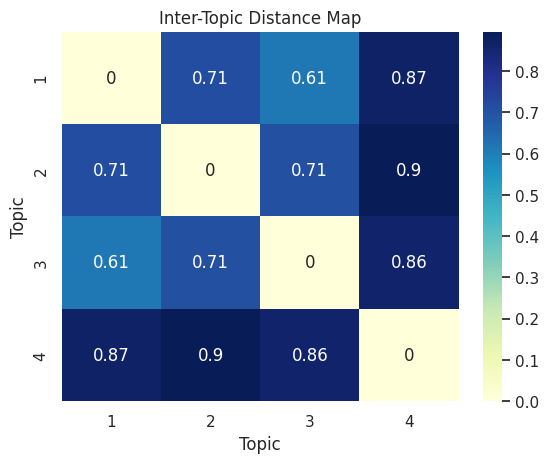

In [68]:
topic_vectors = nmf_model.components_

# Calculate pairwise distances between topic vectors
distances = squareform(pdist(topic_vectors, 'cosine'))

# Create a heatmap for the distance matrix
sns.heatmap(distances, annot=True, cmap='YlGnBu',xticklabels=np.arange(1, len(topic_vectors) + 1), yticklabels=np.arange(1, len(topic_vectors) + 1))
plt.title('Inter-Topic Distance Map')
plt.xlabel('Topic')
plt.ylabel('Topic')
plt.show()

In [69]:
#Display all words
def display_topics(model, feature_names):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[::-1]]
        topics.append("Topic {}: {}".format(topic_idx, ", ".join(top_words)))
    return topics

topics = display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out())
for topic in topics:
    print(topic)


Topic 0: worker, safety, fire, facility, employee, maintain, provide, compliance, factory, medical, sufficient, work, system, emergency, company, safe, free, electric, ensure, hour, quality, hygienic, exit, place, day, available, law, staff, health, center, chemical, training, centre, proper, working, aid, care, insurance, smoke, female, awareness, wear, handle, labor, production, water, designate, work_station, heavy_material, dining, personnel, equip, design, wage, separate, management, level, child, nurse, detector, time, equipment, protection, benefit, doctor, light, pure_drinke, strictly, environment, force, overtime, develop, welfare, hydrant, distribution, social, detection, include, workforce, control, baby, standard, pay, supply, break, respect, group, national, hall, product, conduct, regularly, regular, prayer, alarm, pump, door, zone, area, friendly, human, color, regulation, rule, view, evacuation, customer, adequate, offer, stair, ventilate, complete, pfl, lifestyle, stre

In [70]:

# # Define a function to plot top words for each topic
# def plot_top_words(model, feature_names, n_words, title):
#     fig, axes = plt.subplots(1, n_topics, figsize=(25, 13), sharex=True)
#     axes = axes.flatten()
#     for topic_idx, topic in enumerate(model.components_):
#         top_features_ind = topic.argsort()[:-n_words - 1:-1]
#         top_features = [feature_names[i] for i in top_features_ind]
#         weights = topic[top_features_ind]
#         ax = axes[topic_idx]
#         ax.barh(top_features, weights, height=0.7)
#         ax.set_title(f'Topic {topic_idx +1}', fontdict={'fontsize': 30})
#         ax.invert_yaxis()
#         ax.tick_params(axis='both', which='major', labelsize=20)
#         for i in 'top right left'.split():
#             ax.spines[i].set_visible(False)
#         fig.suptitle(title, fontsize=40)
#     plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
#     plt.show()

# plot_top_words(nmf_model, tfidf_vectorizer.get_feature_names_out(), top_n_words, 'Top words per topic using NMF')

In [71]:
# pip install pyvis

In [72]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plotly_top_words_(model, feature_names, n_words, n_topics):
    cols = n_topics
    subplot_width = 330
    total_width = subplot_width * cols

    subplot_height = max(400, n_words * 20)

    fig = make_subplots(
        rows=1,
        cols=cols,
        subplot_titles=[f'Topic {i+1}' for i in range(n_topics)],
        horizontal_spacing=0.08
    )

    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        fig.add_trace(
            go.Bar(
                x=weights,
                y=top_features,
                orientation='h',
                marker=dict(color=weights, coloraxis="coloraxis")
            ),
            row=1, col=topic_idx+1
        )

        max_weight = weights[0]
        fig.update_xaxes(range=[0, max_weight * 1.1], row=1, col=topic_idx+1)

        fig.update_yaxes(
            autorange="reversed",
            automargin=True,
            row=1,
            col=topic_idx+1
        )

    fig.update_layout(
        coloraxis=dict(colorscale='Blues'),
        showlegend=False,
        height=subplot_height,
        width=total_width,
        title_x=0.5,
        margin=dict(l=20, r=20, t=50, b=20)
    )

    fig.show()



plotly_top_words_(nmf_model, tfidf_vectorizer.get_feature_names_out(), 15, n_topics)


In [73]:
def plotly_topic_distribution(topic_matrix,
                              width=560, height=340,
                              tick_size=20, text_size=18,
                              add_headroom=1.25):
    # dominant topic per doc
    doc_topic = np.argmax(topic_matrix, axis=1)
    counts = np.bincount(doc_topic, minlength=topic_matrix.shape[1])
    topics = [f"Topic {i+1}" for i in range(len(counts))]

    fig = px.bar(x=topics, y=counts,
                 labels={'x': 'Topic', 'y': 'Number of Companies'},
                 text=counts)


    fig.update_traces(
        textposition='outside',
        textfont=dict(size=text_size),
        hovertemplate='<b>%{x}</b><br>Number of Companies: %{y}<extra></extra>'
    )


    y_max = counts.max() if counts.size else 0
    fig.update_yaxes(range=[0, y_max * add_headroom if y_max > 0 else 1],
                     tickfont=dict(size=tick_size))
    fig.update_xaxes(tickfont=dict(size=tick_size))


    fig.update_layout(
        width=width, height=height,
        bargap=0.35,
        margin=dict(l=60, r=20, t=40, b=60),
        uniformtext_minsize=text_size,
        uniformtext_mode='show'
    )

    fig.show()


plotly_topic_distribution(nmf_topic_matrix, width=560, height=330, tick_size=20, text_size=18)


In [74]:
# import numpy as np
# import plotly.express as px

# def plotly_topic_distribution(topic_matrix,
#                               width=540, height=320,
#                               tick_size=12, text_size=12,
#                               add_headroom=1.2,
#                               bar_gap=0.45,
#                               bar_width=0.55):
#     doc_topic = np.argmax(topic_matrix, axis=1)
#     counts = np.bincount(doc_topic, minlength=topic_matrix.shape[1])
#     topics = [f"Topic {i+1}" for i in range(len(counts))]

#     fig = px.bar(x=topics, y=counts,
#                  labels={'x': 'Topic', 'y': 'Number of Companies'},
#                  text=counts)

#     fig.update_traces(
#         textposition='outside',
#         textfont=dict(size=text_size),
#         width=bar_width,
#         marker_line_color='rgba(0,0,0,0.25)',
#         marker_line_width=1
#     )

#     fig.update_xaxes(type='category', tickfont=dict(size=tick_size))
#     y_max = counts.max() if counts.size else 0
#     fig.update_yaxes(range=[0, y_max*add_headroom if y_max > 0 else 1],
#                      tickfont=dict(size=tick_size))

#     fig.update_layout(
#         width=width, height=height,
#         bargap=bar_gap,
#         bargroupgap=0,
#         margin=dict(l=60, r=20, t=40, b=60),
#         uniformtext_minsize=9,
#         uniformtext_mode='hide'
#     )
#     fig.show()


# plotly_topic_distribution(nmf_topic_matrix, bar_gap=0.45, bar_width=0.55)


In [75]:
# import matplotlib.pyplot as plt
# import networkx as nx

# # Assuming 'topics' is a list of topics with their top keywords
# # Example modified for brevity: ['Topic 0: word1, word2, word3', 'Topic 1: word1, word2, word3']

# G = nx.Graph()

# # Add nodes with the topic label, increase size for better visibility
# for i in range(len(topics)):
#     G.add_node(f"Topic {i}", size=40, color='skyblue')  # Increase the size value here

# # Extract keywords for each topic and add them to the graph, limit to top 20 keywords
# for i, topic in enumerate(topics):
#     keywords = topic.split(": ")[1].split(", ")[:20]  # Limit keywords to top 20
#     for word in keywords:
#         G.add_node(word, size=15, color='#ff9f1c')  # Increase the size value here
#         G.add_edge(f"Topic {i}", word)





In [76]:
# plt.figure(figsize=(12, 8))


# pos = nx.spring_layout(G, k=0.20, iterations=30)
# sizes = [G.nodes[node]['size'] * 70 for node in G.nodes]
# colors = [G.nodes[node]['color'] for node in G.nodes]

# nx.draw(G, pos, with_labels=True, node_size=sizes, node_color=colors, font_size=10, font_weight='bold')

# plt.title("NMF Topics and Top 20 Keywords", fontsize=14)
# plt.axis('off')
# plt.show()

In [77]:
# import matplotlib.pyplot as plt
# import networkx as nx

# G = nx.Graph()


# topic_names = {0: 'Social', 1: 'Environmental', 2: 'Social', 3: 'Governance'}

# for i in range(len(topics)):
#     topic_label = topic_names.get(i, f"Topic {i}")
#     G.add_node(topic_label, size=40, color='skyblue')

# # Extract keywords for each topic and add them to the graph, limit to top 20 keywords
# for i, topic in enumerate(topics):
#     topic_label = topic_names.get(i, f"Topic {i}")
#     keywords = topic.split(": ")[1].split(", ")[:8]
#     for word in keywords:
#         G.add_node(word, size=15, color='#ff9f1c')
#         G.add_edge(topic_label, word)


# plt.figure(figsize=(4, 5))


# pos = nx.spring_layout(G, k=0.26, iterations=30)

# sizes = [G.nodes[node]['size'] * 50 for node in G.nodes]  # Node size
# colors = [G.nodes[node]['color'] for node in G.nodes]  # Node color

# nx.draw(G, pos, with_labels=True, node_size=sizes, node_color=colors, font_size=10, font_weight='bold')

# plt.title("NMF Topics and Keywords", fontsize=20)
# plt.axis('off')
# plt.show()


In [78]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

df['Processed_Text'] = processed_texts
# Tokenize the processed text for gensim
texts = [text.split() for text in df['Processed_Text']]

# Create a dictionary representation
dictionary = Dictionary(texts)

# Convert the tokenized texts into a bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in texts]

# Gensim's NMF model for coherence computation
gensim_nmf = Nmf(corpus, num_topics=n_topics,passes=5,minimum_probability=0, id2word=dictionary, random_state=42,eval_every=10,chunksize=1000)

# Compute coherence score
coherence_model = CoherenceModel(model=gensim_nmf, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()

coherence_score

np.float64(0.359635733335822)

In [79]:
!pip install nltk


### **Extracting relevant sentences**

In [80]:
%pip -q install nltk
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')  # some NLTK versions require this too
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [81]:
def display_topics1(model, feature_names, n_words):
    topics = {idx: [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]] for idx, topic in enumerate(model.components_)}
    return topics

top_n_words = 20
topics = display_topics1(nmf_model, tfidf_vectorizer.get_feature_names_out(), top_n_words)

# Function to extract relevant sentences
def extract_relevant_sentences(all_docs, topics):
    sentences_by_topic = {i: [] for i in topics}
    for doc in all_docs:
        sentences = sent_tokenize(doc)
        for sentence in sentences:
            lower_sentence = sentence.lower()
            for topic_id, keywords in topics.items():
                if any(re.search(r'\b' + re.escape(keyword) + r'\b', lower_sentence) for keyword in keywords):
                    sentences_by_topic[topic_id].append(sentence)
    return sentences_by_topic

# Extract sentences for each topic
relevant_sentences = extract_relevant_sentences(df['Text'].tolist(), topics)

# Print the top 12 keywords for each topic
for topic_id, keywords in topics.items():
    print(f"Topic {topic_id}: {keywords}")
print('\n')
# Print the relevant sentences
for topic_id, sentences in relevant_sentences.items():
    print(f"Topic {topic_id}: {sentences[:10]}")

Topic 0: ['worker', 'safety', 'fire', 'facility', 'employee', 'maintain', 'provide', 'compliance', 'factory', 'medical', 'sufficient', 'work', 'system', 'emergency', 'company', 'safe', 'free', 'electric', 'ensure', 'hour']
Topic 1: ['sustainability', 'water', 'environmental', 'business', 'reduce', 'environment', 'energy', 'waste', 'product', 'sustainable', 'group', 'work', 'customer', 'report', 'consumption', 'initiative', 'community', 'goal', 'production', 'standard']
Topic 2: ['program', 'worker', 'school', 'provide', 'health', 'education', 'support', 'student', 'child', 'free', 'employee', 'year', 'project', 'community', 'scholarship', 'donate', 'foundation', 'start', 'group', 'poor']
Topic 3: ['art', 'pediatric', 'burn', 'appointment', 'unit', 'people', 'intensive', 'state', 'competition', 'care', 'responsibility', 'child', 'mechanical', 'proactively', 'artwork', 'conditioner', 'picture', 'neighborhood', 'promptly', 'relationnew']


Topic 0: ['"Safety & Compliance Our Strengths are

### **Centrality Analysis**

In [82]:
from collections import defaultdict
import networkx as nx
from itertools import combinations

In [83]:

feature_names = tfidf_vectorizer.get_feature_names_out()

def display_topics2(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx + 1))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("\n")
# Number of words to display per topic
no_top_words = 15

feature_names = tfidf_vectorizer.get_feature_names_out()
topics_words = {idx: [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]] for idx, topic in enumerate(nmf_model.components_)}

# Define a minimum co-occurrence threshold to consider for edge creation
min_co_occurrence = 5

# Create a co-occurrence matrix for each topic
topic_co_occurrence_matrices = defaultdict(lambda: defaultdict(int))
for topic_idx, words in topics_words.items():
    for doc in data_ready:

        doc_words = set(word for word in doc if word in words)
        for w1, w2 in combinations(doc_words, 2):
            if w1 != w2:
                topic_co_occurrence_matrices[topic_idx][(w1, w2)] += 1

# Calculate degree, closeness, and eigenvector centrality for each word in each topic
centrality_measures = defaultdict(lambda: {"degree": {}, "closeness": {}, "eigenvector": {}})
for topic_idx, co_occ_matrix in topic_co_occurrence_matrices.items():
    G = nx.Graph()
    for (w1, w2), weight in co_occ_matrix.items():
        if weight >= min_co_occurrence:
            G.add_edge(w1, w2, weight=weight)
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    try:
        eigenvector_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')
    except nx.NetworkXError as e:
        print(f"Error in computing eigenvector centrality for topic {topic_idx}: {e}")
        eigenvector_centrality = {}
    centrality_measures[topic_idx]["degree"] = degree_centrality
    centrality_measures[topic_idx]["closeness"] = closeness_centrality
    centrality_measures[topic_idx]["eigenvector"] = eigenvector_centrality

# Print the top words by centrality measures for each topic
for topic_idx, measures in centrality_measures.items():
    display_idx = topic_idx + 1
    print(f"Centrality measures for Topic {display_idx}:")
    print("\n")
    print("Top words by degree centrality:")
    sorted_degree = sorted(measures["degree"].items(), key=lambda item: item[1], reverse=True)
    for word, centrality_score in sorted_degree[:15]:
        print(f"{word}: {centrality_score:.4f}")
    print("\n")
    print("Top words by closeness centrality:")
    sorted_closeness = sorted(measures["closeness"].items(), key=lambda item: item[1], reverse=True)
    for word, centrality_score in sorted_closeness[:15]:
        print(f"{word}: {centrality_score:.4f}")
    print("\n")
    print("Top words by eigenvector centrality:")
    sorted_eigenvector = sorted(measures["eigenvector"].items(), key=lambda item: item[1], reverse=True)
    for word, centrality_score in sorted_eigenvector[:15]:
        print(f"{word}: {centrality_score:.3f}")
    print("\n")




Centrality measures for Topic 1:


Top words by degree centrality:
maintain: 1.0000
medical: 1.0000
facility: 1.0000
worker: 1.0000
system: 1.0000
employee: 1.0000
factory: 1.0000
sufficient: 1.0000
emergency: 1.0000
company: 1.0000
compliance: 1.0000
fire: 1.0000
provide: 1.0000
safety: 1.0000
work: 1.0000


Top words by closeness centrality:
maintain: 1.0000
medical: 1.0000
facility: 1.0000
worker: 1.0000
system: 1.0000
employee: 1.0000
factory: 1.0000
sufficient: 1.0000
emergency: 1.0000
company: 1.0000
compliance: 1.0000
fire: 1.0000
provide: 1.0000
safety: 1.0000
work: 1.0000


Top words by eigenvector centrality:
work: 0.339
employee: 0.321
facility: 0.314
worker: 0.306
provide: 0.299
factory: 0.273
medical: 0.272
safety: 0.268
system: 0.239
company: 0.232
fire: 0.210
maintain: 0.208
compliance: 0.199
emergency: 0.189
sufficient: 0.083


Centrality measures for Topic 2:


Top words by degree centrality:
water: 1.0000
group: 1.0000
environment: 1.0000
sustainability: 1.0000
wast

/tmp/ipython-input-875995599.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




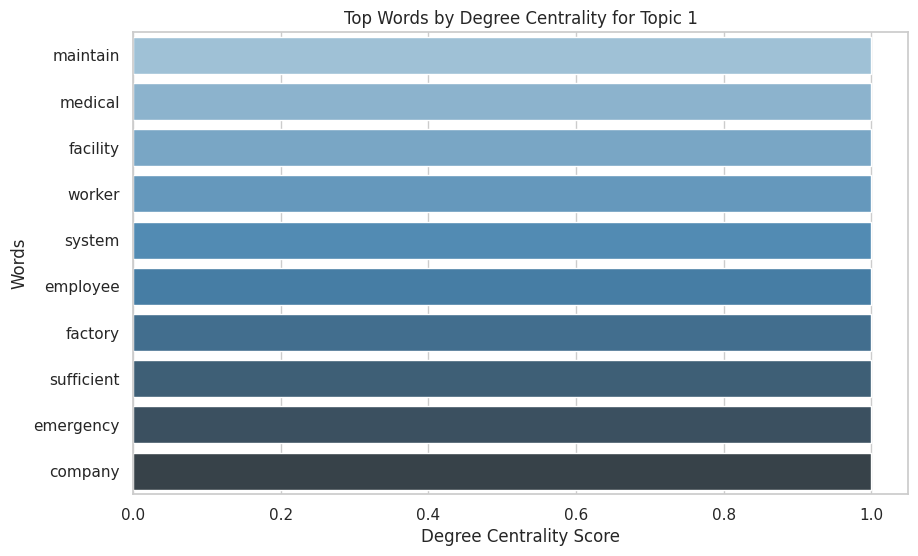

/tmp/ipython-input-875995599.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




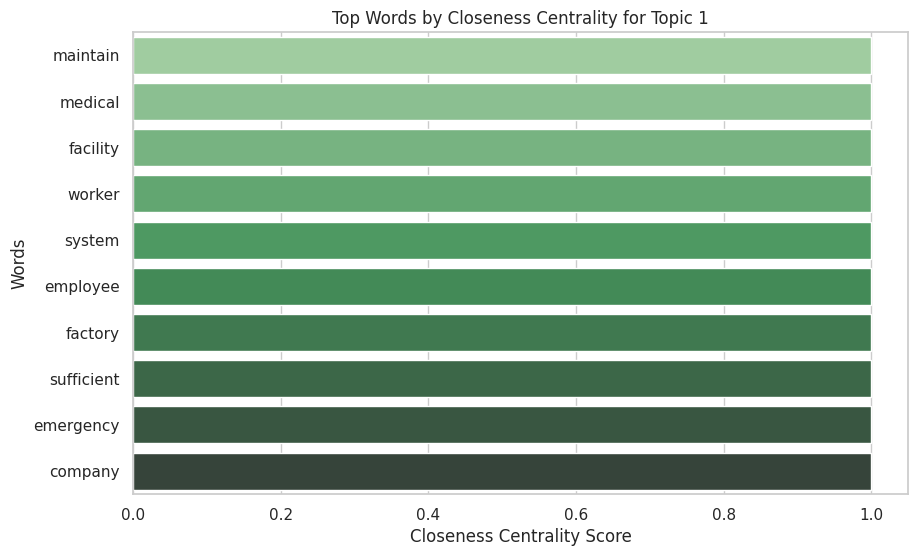

/tmp/ipython-input-875995599.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




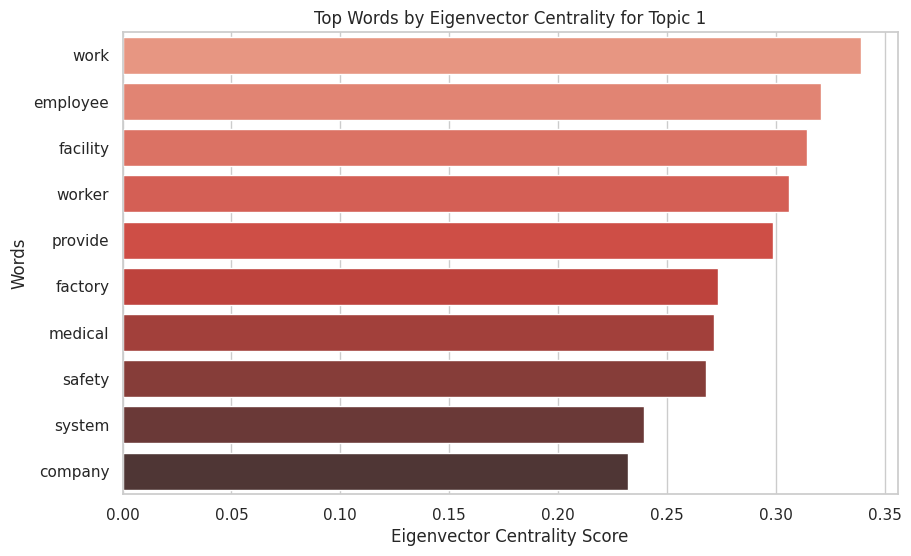

/tmp/ipython-input-875995599.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




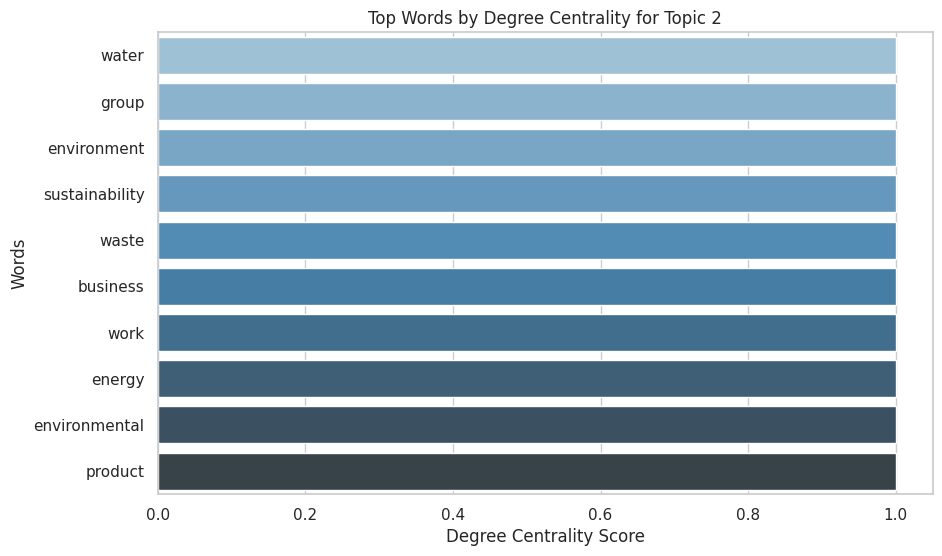

/tmp/ipython-input-875995599.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




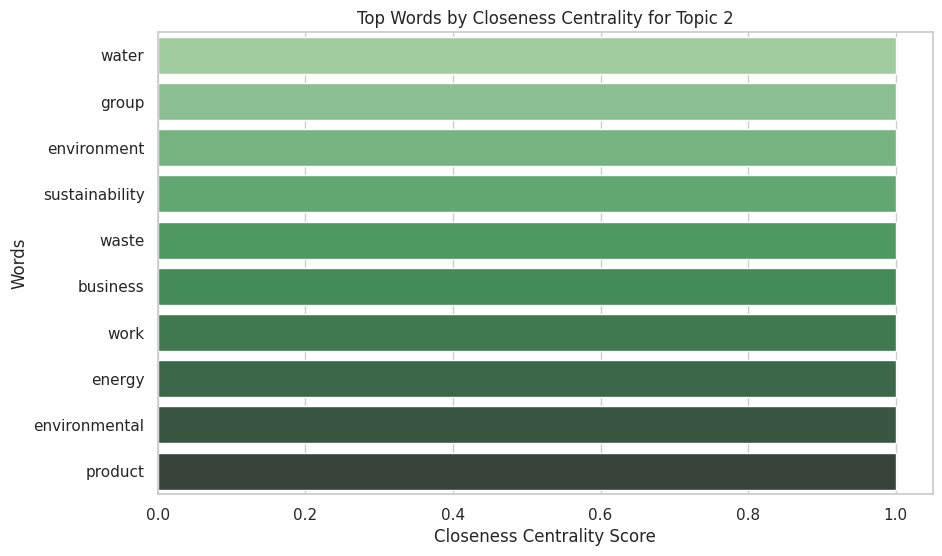

/tmp/ipython-input-875995599.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




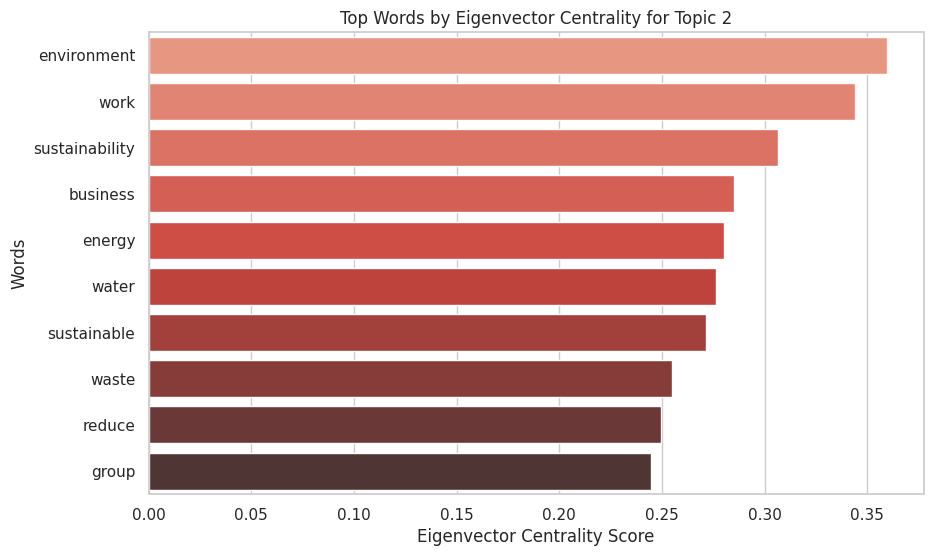

/tmp/ipython-input-875995599.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




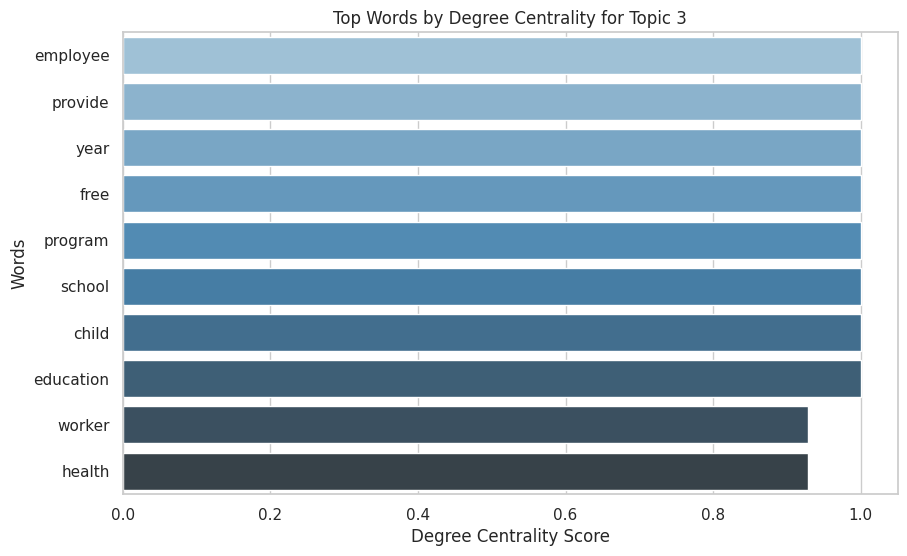

/tmp/ipython-input-875995599.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




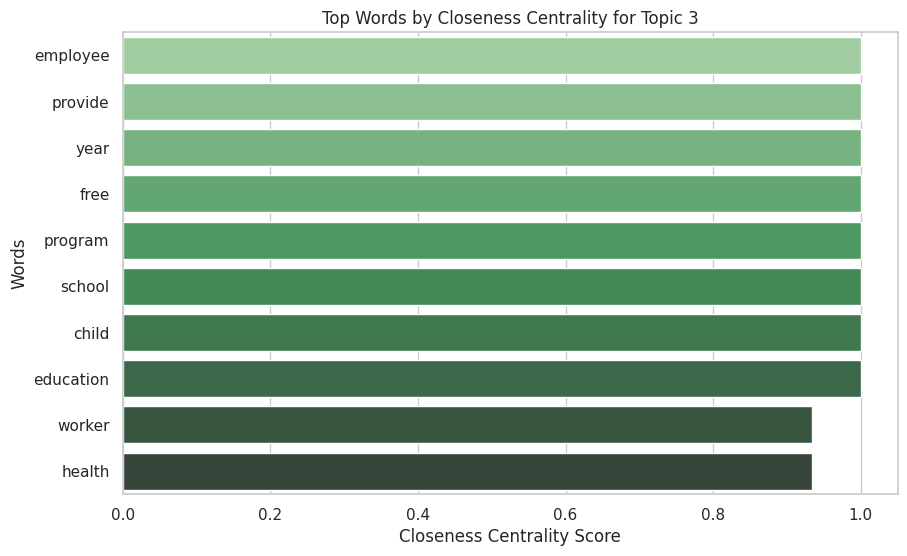

/tmp/ipython-input-875995599.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




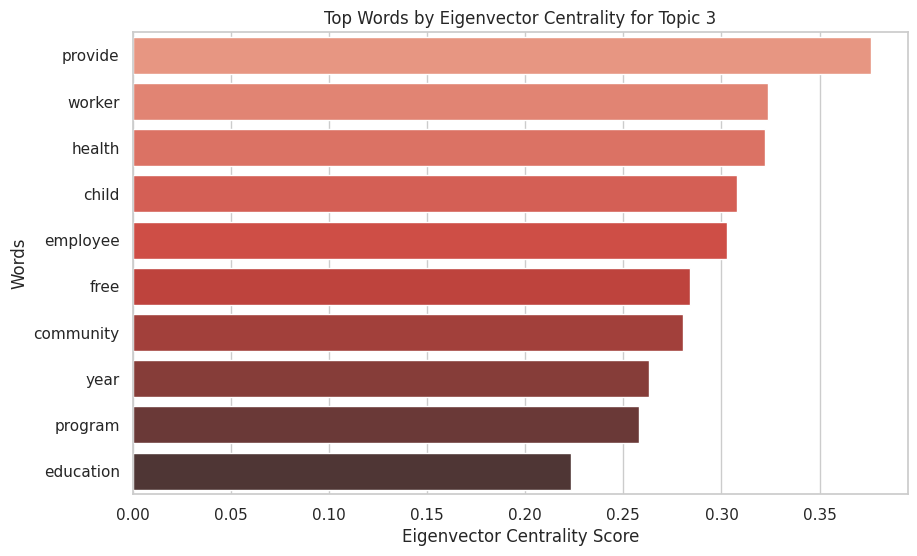

/tmp/ipython-input-875995599.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




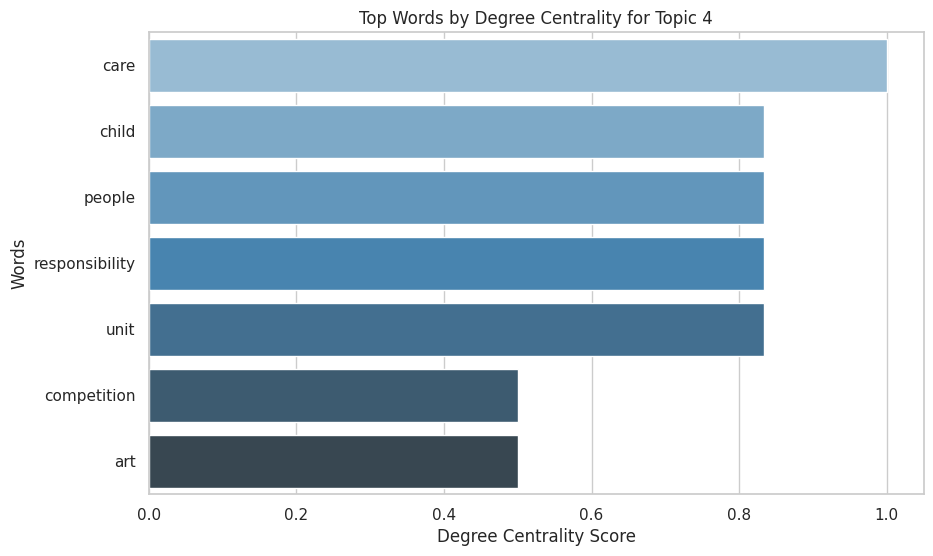

/tmp/ipython-input-875995599.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




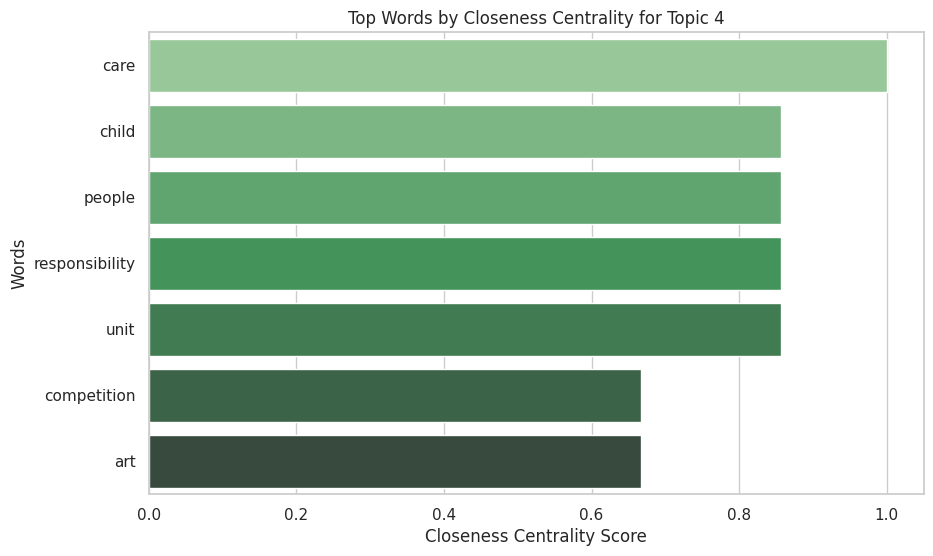

/tmp/ipython-input-875995599.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




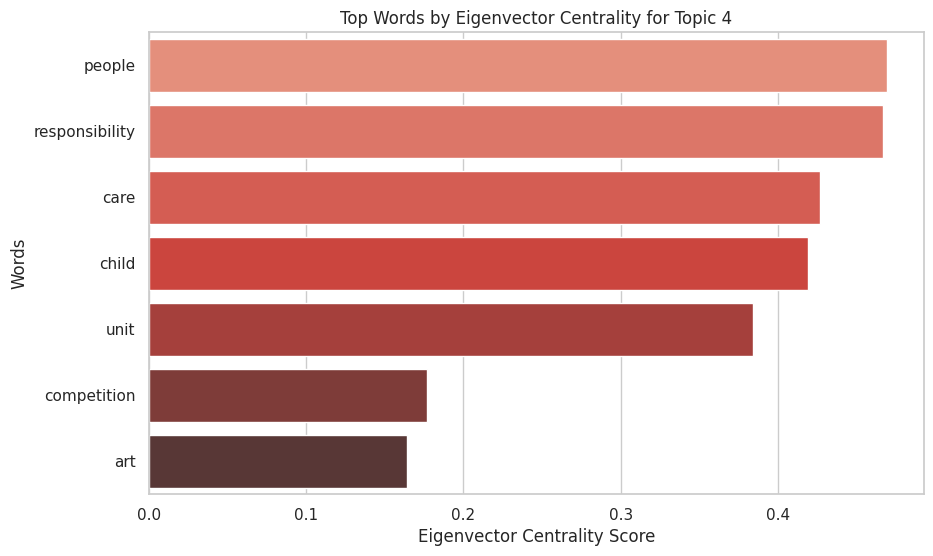

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_centrality_measures(centrality_measures, top_n=10):
    """
    Visualizes centrality measures (degree, closeness, eigenvector) as bar plots for each topic.
    """
    for topic_idx, measures in centrality_measures.items():
        display_idx = topic_idx + 1

        # --- Bar Plot for Degree Centrality ---
        plt.figure(figsize=(10, 6))
        sorted_degree = sorted(measures["degree"].items(), key=lambda item: item[1], reverse=True)[:top_n]
        words, scores = zip(*sorted_degree)
        sns.barplot(x=scores, y=words, palette='Blues_d')
        plt.title(f'Top Words by Degree Centrality for Topic {display_idx}')
        plt.xlabel('Degree Centrality Score')
        plt.ylabel('Words')
        plt.show()

        # --- Bar Plot for Closeness Centrality ---
        plt.figure(figsize=(10, 6))
        sorted_closeness = sorted(measures["closeness"].items(), key=lambda item: item[1], reverse=True)[:top_n]
        words, scores = zip(*sorted_closeness)
        sns.barplot(x=scores, y=words, palette='Greens_d')
        plt.title(f'Top Words by Closeness Centrality for Topic {display_idx}')
        plt.xlabel('Closeness Centrality Score')
        plt.ylabel('Words')
        plt.show()

        # --- Bar Plot for Eigenvector Centrality ---
        plt.figure(figsize=(10, 6))
        sorted_eigenvector = sorted(measures["eigenvector"].items(), key=lambda item: item[1], reverse=True)[:top_n]
        words, scores = zip(*sorted_eigenvector)
        sns.barplot(x=scores, y=words, palette='Reds_d')
        plt.title(f'Top Words by Eigenvector Centrality for Topic {display_idx}')
        plt.xlabel('Eigenvector Centrality Score')
        plt.ylabel('Words')
        plt.show()

# Visualize centrality measures for each topic
visualize_centrality_measures(centrality_measures, top_n=10)


In [85]:
# import matplotlib.pyplot as plt
# import networkx as nx
# from math import ceil

# def visualize_word_co_occurrence_networks_2_columns_smaller(topic_co_occurrence_matrices, min_co_occurrence=5):

#     num_topics = len(topic_co_occurrence_matrices)
#     # Calculate number of rows
#     num_rows = ceil(num_topics / 2)


#     fig, axes = plt.subplots(num_rows, 2, figsize=(10, num_rows * 4))
#     axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

#     for idx, (topic_idx, co_occ_matrix) in enumerate(topic_co_occurrence_matrices.items()):
#         display_idx = topic_idx + 1

#         # Create a graph for the current topic
#         G = nx.Graph()

#         # Add edges with weights to the graph
#         for (w1, w2), weight in co_occ_matrix.items():
#             if weight >= min_co_occurrence:
#                 G.add_edge(w1, w2, weight=weight)

#         # Calculate positions for all nodes
#         pos = nx.spring_layout(G, k=0.5, seed=42)

#         # Calculate node sizes based on degree centrality
#         node_size = [v * 300 for v in nx.degree_centrality(G).values()]
#         # Calculate edge widths based on weight
#         edge_width = [d['weight'] * 0.05 for (u, v, d) in G.edges(data=True)]

#         # Draw the network graph
#         ax = axes[idx]
#         nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='skyblue', alpha=0.7, ax=ax)
#         nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6, ax=ax)
#         nx.draw_networkx_labels(G, pos, font_size=7, font_family="sans-serif", font_weight='bold', ax=ax)

#         # Add title to the plot
#         ax.set_title(f'Word Co-occurrence Network for Topic {display_idx}', fontsize=10)
#         ax.axis('off')

#     # Hide any remaining empty subplots
#     for i in range(idx + 1, len(axes)):
#         axes[i].axis('off')

#     # Adjust layout
#     plt.tight_layout(pad=1.5)
#     plt.show()

# # Visualize word co-occurrence networks for each topic
# visualize_word_co_occurrence_networks_2_columns_smaller(topic_co_occurrence_matrices, min_co_occurrence=5)


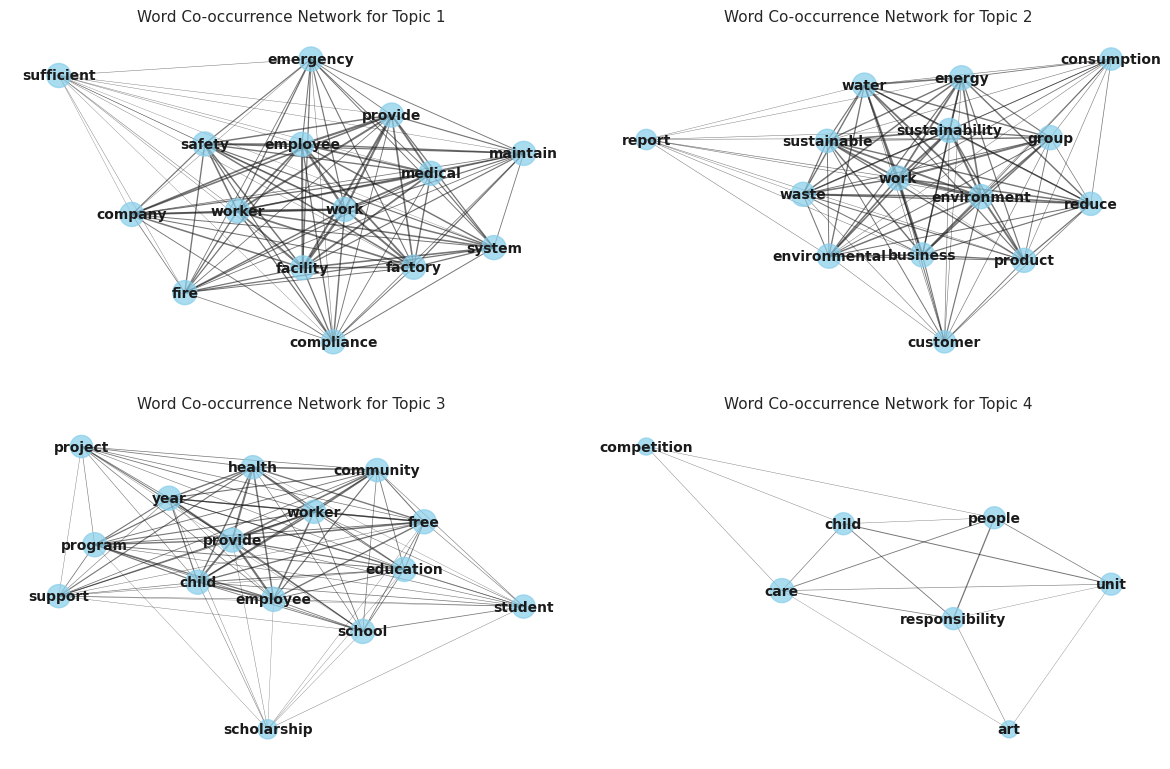

In [86]:
import matplotlib.pyplot as plt
import networkx as nx
from math import ceil

def visualize_word_co_occurrence_networks_2_columns_smaller(topic_co_occurrence_matrices, min_co_occurrence=5):

    num_topics = len(topic_co_occurrence_matrices)
    num_rows = ceil(num_topics / 2)

    fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
    axes = axes.flatten()

    for idx, (topic_idx, co_occ_matrix) in enumerate(topic_co_occurrence_matrices.items()):
        display_idx = topic_idx + 1

        G = nx.Graph()
        for (w1, w2), weight in co_occ_matrix.items():
            if weight >= min_co_occurrence:
                G.add_edge(w1, w2, weight=weight)

        pos = nx.spring_layout(G, k=0.5, seed=42)

        node_size = [v * 300 for v in nx.degree_centrality(G).values()]
        edge_width = [d['weight'] * 0.05 for (u, v, d) in G.edges(data=True)]

        ax = axes[idx]
        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='skyblue', alpha=0.7, ax=ax)
        nx.draw_networkx_edges(G, pos, width=edge_width, alpha=0.6, ax=ax)

        nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif", font_weight='bold', ax=ax)

        ax.set_title(f'Word Co-occurrence Network for Topic {display_idx}', fontsize=11)
        ax.axis('off')

    for i in range(idx + 1, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(pad=1.5)
    plt.show()

# Visualize word co-occurrence networks for each topic in a more compact two-column layout
visualize_word_co_occurrence_networks_2_columns_smaller(topic_co_occurrence_matrices, min_co_occurrence=5)


/tmp/ipython-input-1021993805.py:21: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/tmp/ipython-input-1021993805.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1021993805.py:31: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/tmp/ipython-input-1021993805.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1021993805.py:41: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/tmp/ipython-input-1021993805.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` va

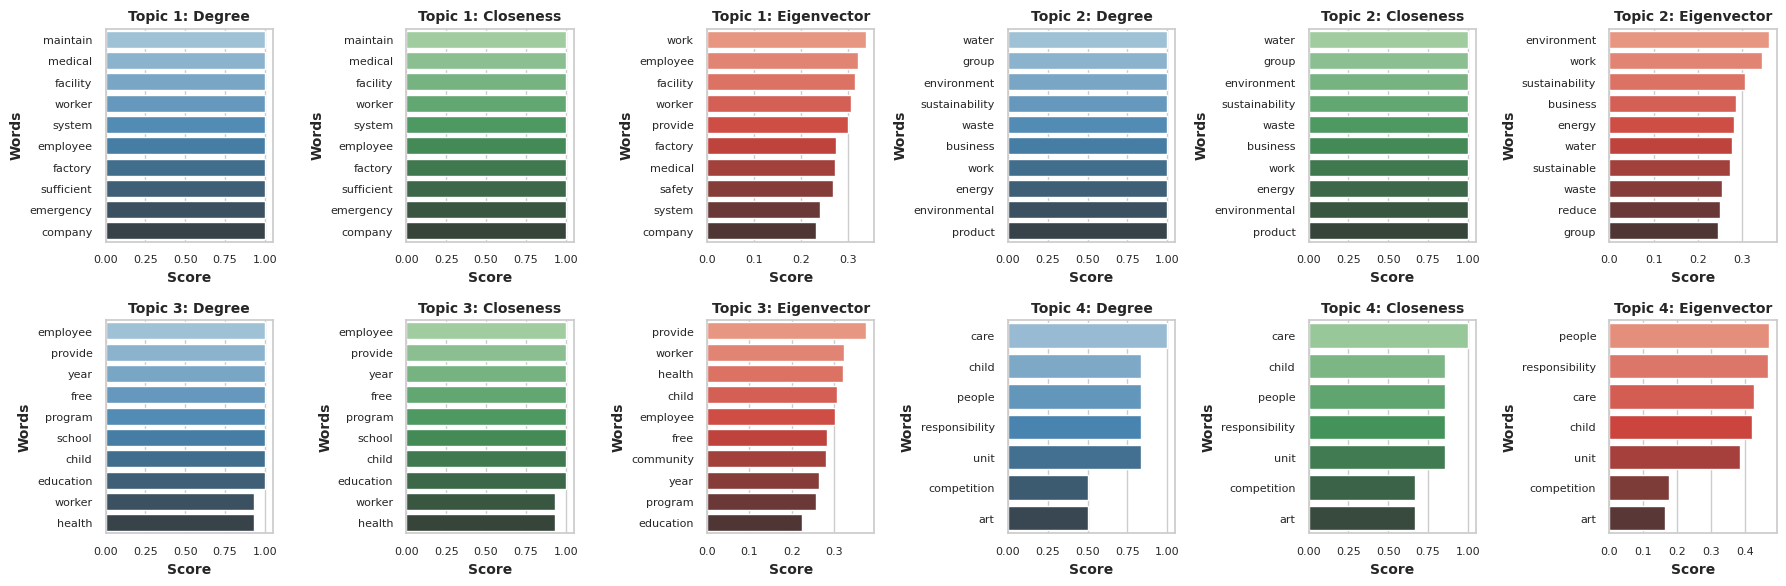

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_centrality_measures_grid_2x6(centrality_measures, top_n=10):
    """
    Visualizes centrality measures (degree, closeness, eigenvector) as bar plots for each topic
    in a compact 2x6 grid layout with improved axis label styling.
    """

    fig, axes = plt.subplots(2, 6, figsize=(18, 6))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

    plot_idx = 0  # Initialize plot index

    for topic_idx, measures in centrality_measures.items():
        display_idx = topic_idx + 1

        # --- Bar Plot for Degree Centrality ---
        sorted_degree = sorted(measures["degree"].items(), key=lambda item: item[1], reverse=True)[:top_n]
        words, scores = zip(*sorted_degree)
        sns.barplot(x=scores, y=words, palette='Blues_d', ax=axes[plot_idx], ci=None)
        axes[plot_idx].set_title(f'Topic {display_idx}: Degree', fontsize=10, fontweight='bold')
        axes[plot_idx].set_xlabel('Score', fontsize=10, fontweight='bold')
        axes[plot_idx].set_ylabel('Words', fontsize=10, fontweight='bold')
        axes[plot_idx].tick_params(labelsize=8)
        plot_idx += 1

        # --- Bar Plot for Closeness Centrality ---
        sorted_closeness = sorted(measures["closeness"].items(), key=lambda item: item[1], reverse=True)[:top_n]
        words, scores = zip(*sorted_closeness)
        sns.barplot(x=scores, y=words, palette='Greens_d', ax=axes[plot_idx], ci=None)
        axes[plot_idx].set_title(f'Topic {display_idx}: Closeness', fontsize=10, fontweight='bold')
        axes[plot_idx].set_xlabel('Score', fontsize=10, fontweight='bold')
        axes[plot_idx].set_ylabel('Words', fontsize=10, fontweight='bold')
        axes[plot_idx].tick_params(labelsize=8)
        plot_idx += 1

        # --- Bar Plot for Eigenvector Centrality ---
        sorted_eigenvector = sorted(measures["eigenvector"].items(), key=lambda item: item[1], reverse=True)[:top_n]
        words, scores = zip(*sorted_eigenvector)
        sns.barplot(x=scores, y=words, palette='Reds_d', ax=axes[plot_idx], ci=None)
        axes[plot_idx].set_title(f'Topic {display_idx}: Eigenvector', fontsize=10, fontweight='bold')
        axes[plot_idx].set_xlabel('Score', fontsize=10, fontweight='bold')
        axes[plot_idx].set_ylabel('Words', fontsize=10, fontweight='bold')
        axes[plot_idx].tick_params(labelsize=8)
        plot_idx += 1

    # Hide any remaining empty subplots
    for i in range(plot_idx, len(axes)):
        axes[i].axis('off')

    # Adjust layout
    plt.tight_layout(pad=1.0)
    plt.show()

# Visualize centrality measures for each topic
visualize_centrality_measures_grid_2x6(centrality_measures, top_n=10)


In [88]:
count_vectorizer = CountVectorizer()
X = count_vectorizer.fit_transform([' '.join(text) for text in data_ready])
Xc = (X.T * X)  # This is the matrix multiplication step to get the co-occurrence matrix
Xc.setdiag(0)  # Set diagonals to 0

# Convert to CSV for NetDraw
co_occ_df = pd.DataFrame(Xc.toarray(), index=count_vectorizer.get_feature_names_out(), columns=count_vectorizer.get_feature_names_out())
edge_list = co_occ_df.stack().reset_index()
edge_list.columns = ['Source', 'Target', 'Weight']
edge_list = edge_list[edge_list['Weight'] > 0]  # Filter out zero weights
edge_list.to_csv('co_occurrence_edge_list.csv', index=False)

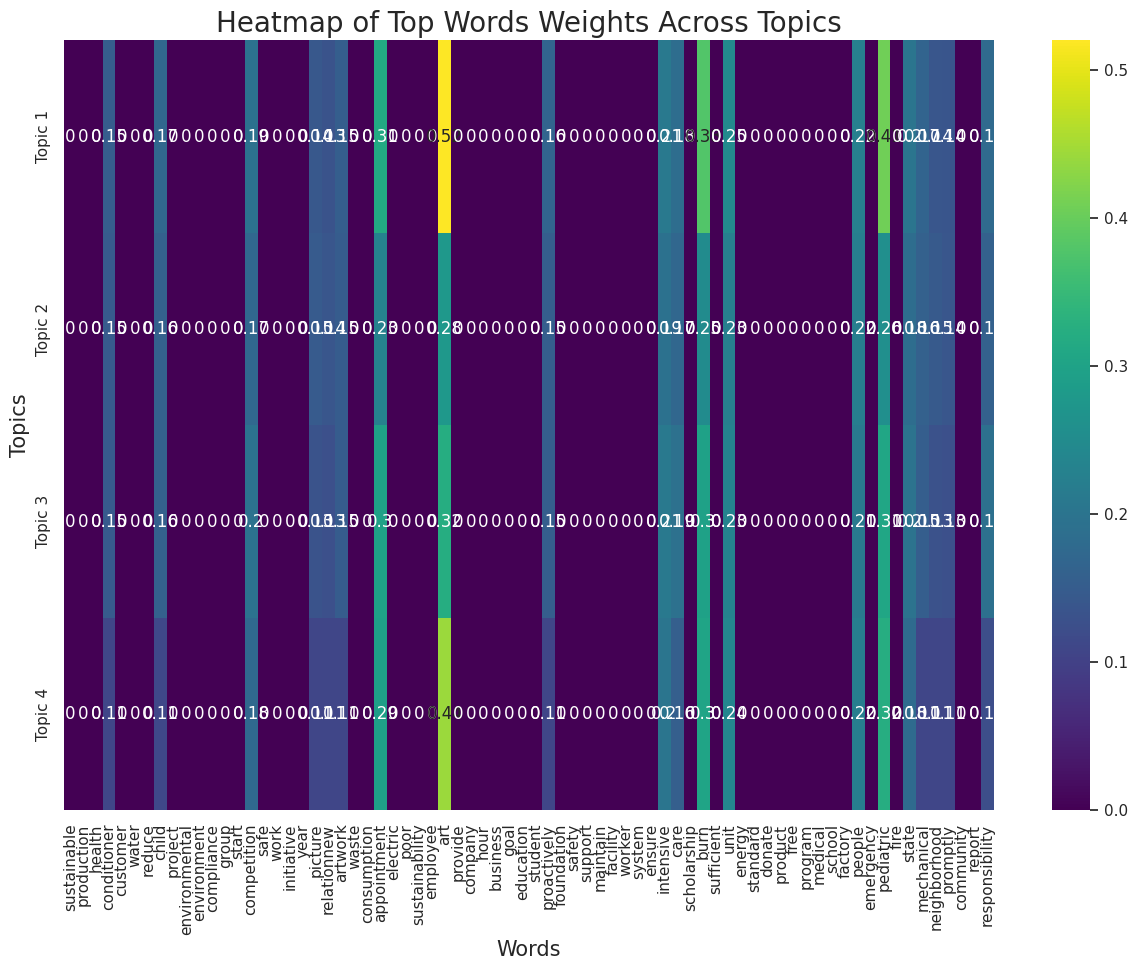

In [89]:

import seaborn as sns

def plot_heatmap(model, feature_names, n_words):
    # Extracting the components
    components = model.components_
    word_weights = []
    words = []

    # Extracting top words and their weights for each topic
    for topic in components:
        top_features_ind = topic.argsort()[:-n_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        word_weights.append(weights)
        words.extend(top_features)

    words = list(set(words))  # removing duplicates
    heatmap_data = []


    for topic_weights in word_weights:
        row = []
        for word in words:
            if word in feature_names[top_features_ind]:
                row.append(topic_weights[list(feature_names[top_features_ind]).index(word)])
            else:
                row.append(0)
        heatmap_data.append(row)

    plt.figure(figsize=(15, 10))
    sns.heatmap(heatmap_data, annot=True, cmap='viridis', yticklabels=[f"Topic {i+1}" for i in range(n_topics)], xticklabels=words)
    plt.title('Heatmap of Top Words Weights Across Topics', fontsize=20)
    plt.xlabel('Words', fontsize=15)
    plt.ylabel('Topics', fontsize=15)
    plt.show()

plot_heatmap(nmf_model, tfidf_vectorizer.get_feature_names_out(), top_n_words)


In [90]:
# # Create the nmf_topic_matrix_df DataFrame
# nmf_topic_matrix_df = pd.DataFrame(nmf_topic_matrix, columns=[f'Topic{i+1}' for i in range(n_topics)])

# # Adding company names to the DataFrame for reference
# nmf_topic_matrix_df['Company'] = df['Company names']

# nmf_topic_matrix_df = nmf_topic_matrix_df[['Company'] + [f'Topic{i+1}' for i in range(n_topics)]]

# # Adding a new column that indicates the topic number with the highest score for each company
# nmf_topic_matrix_df['Dominant_Topic'] = nmf_topic_matrix_df.iloc[:, 1:].idxmax(axis=1)


# # Display the DataFrame
# print(nmf_topic_matrix_df.head())

In [91]:
# Create the nmf_topic_matrix_df DataFrame
nmf_topic_matrix_df1 = pd.DataFrame(nmf_topic_matrix, columns=[f'Topic{i+1}' for i in range(n_topics)])

# Adding company names and Cert Level to the DataFrame for reference
nmf_topic_matrix_df1['Company'] = df['Company names']
nmf_topic_matrix_df1['CertLevel'] = df['CertLevel']

# Filter the DataFrame to include only companies with non-empty Cert Level
nmf_topic_matrix_df1 = nmf_topic_matrix_df1[nmf_topic_matrix_df1['CertLevel'].notna()]

# Reorder columns
nmf_topic_matrix_df1 = nmf_topic_matrix_df1[['Company', 'CertLevel'] + [f'Topic{i+1}' for i in range(n_topics)]]

# Adding a new column that indicates the topic number with the highest score for each company
nmf_topic_matrix_df1['Dominant_Topic'] = nmf_topic_matrix_df1.iloc[:, 2:].idxmax(axis=1)

# Display the DataFrame
print(nmf_topic_matrix_df1.head())
print("Number of rows in the DataFrame:", len(nmf_topic_matrix_df1))

             Company      CertLevel    Topic1    Topic2    Topic3    Topic4  \
0                A&G  Not Certified  0.481074  0.000000  0.000000  0.000000   
1           AKH echo           Gold  0.000000  0.149700  0.162939  0.000000   
2          Akij jute  Not Certified  0.000000  0.000000  0.372383  0.001072   
3      Alphaclothing           Gold  0.113172  0.000000  0.345318  0.000000   
4  Aman text limited       Platinum  0.000000  0.013486  0.119486  0.011785   

  Dominant_Topic  
0         Topic1  
1         Topic3  
2         Topic3  
3         Topic3  
4         Topic3  
Number of rows in the DataFrame: 82


In [92]:
# Create the nmf_topic_matrix_df DataFrame
nmf_topic_matrix_df1 = pd.DataFrame(nmf_topic_matrix, columns=[f'Topic{i+1}' for i in range(n_topics)])

# Adding company names and Cert Level to the DataFrame for reference
nmf_topic_matrix_df1['Company'] = df['Company names']
nmf_topic_matrix_df1['CertLevel'] = df['CertLevel']

# Filter the DataFrame to include only companies with non-empty Cert Level
nmf_topic_matrix_df1 = nmf_topic_matrix_df1[nmf_topic_matrix_df1['CertLevel'].notna()]

# Rename Topic1, Topic2, Topic3, and Topic4
topic_rename = {
    'Topic1': 'Social1',
    'Topic2': 'Environmental',
    'Topic3': 'Social2',
    'Topic4': 'Governance'
}

# Apply the new topic names
nmf_topic_matrix_df1.rename(columns=topic_rename, inplace=True)

# Reorder columns, using unique names for each topic to avoid overwriting
nmf_topic_matrix_df1 = nmf_topic_matrix_df1[['Company', 'CertLevel', 'Social1', 'Environmental', 'Social2', 'Governance']]

# Adding a new column that indicates the topic number with the highest score for each company
nmf_topic_matrix_df1['Dominant_Topic'] = nmf_topic_matrix_df1.iloc[:, 2:].idxmax(axis=1)

# Display the DataFrame
print(nmf_topic_matrix_df1.head())


             Company      CertLevel   Social1  Environmental   Social2  \
0                A&G  Not Certified  0.481074       0.000000  0.000000   
1           AKH echo           Gold  0.000000       0.149700  0.162939   
2          Akij jute  Not Certified  0.000000       0.000000  0.372383   
3      Alphaclothing           Gold  0.113172       0.000000  0.345318   
4  Aman text limited       Platinum  0.000000       0.013486  0.119486   

   Governance Dominant_Topic  
0    0.000000        Social1  
1    0.000000        Social2  
2    0.001072        Social2  
3    0.000000        Social2  
4    0.011785        Social2  


Dominant_Topic  Environmental  Governance  Social1  Social2
CertLevel                                                  
Gold                       10           0        3        8
Not Certified              14           2        8       11
Platinum                   14           2        4        5
Silver                      0           0        0        1


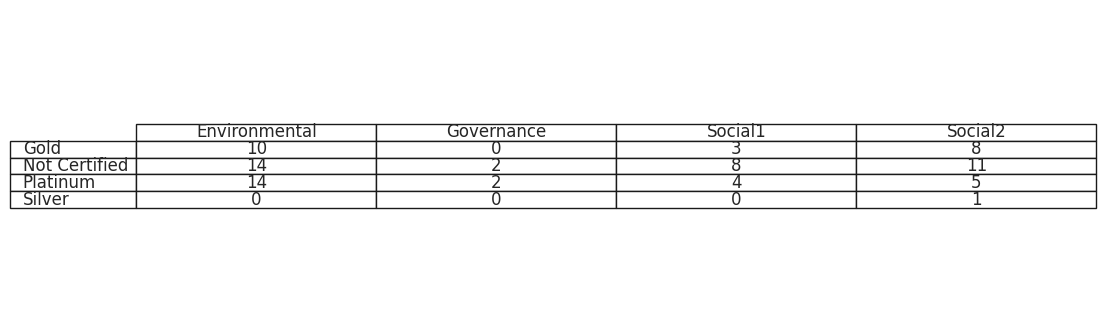

In [93]:
freq_table1 = pd.pivot_table(nmf_topic_matrix_df1, index='CertLevel', columns='Dominant_Topic', aggfunc='size', fill_value=0)

# Display the frequency table
print(freq_table1)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=freq_table1.values, colLabels=freq_table1.columns, rowLabels=freq_table1.index, loc='center', cellLoc='center')

plt.subplots_adjust(left=0.1, bottom=0.1)

plt.show()

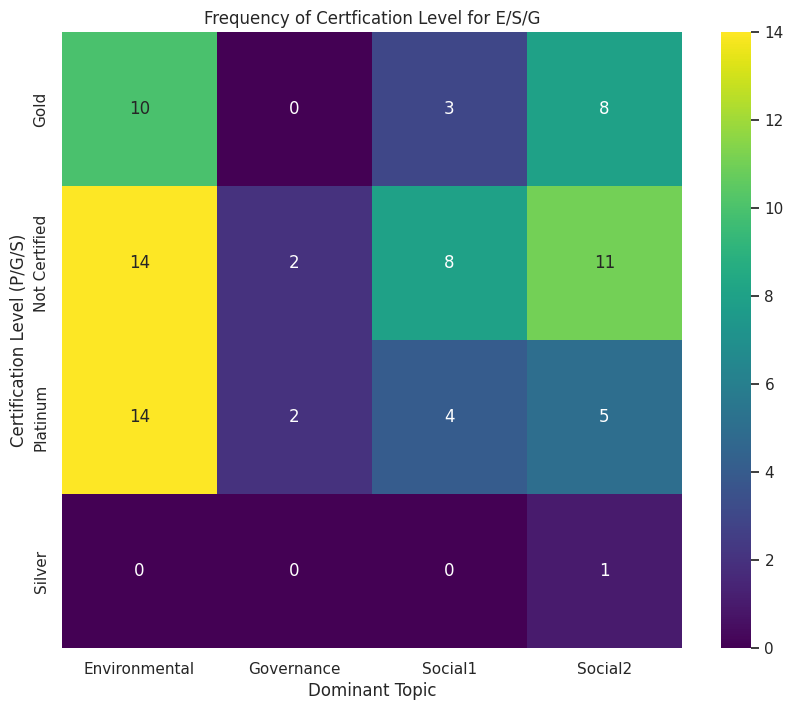

In [94]:
freq_table = pd.pivot_table(nmf_topic_matrix_df1, index='CertLevel', columns='Dominant_Topic', aggfunc='size', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(freq_table, annot=True, fmt="d", cmap='viridis')
plt.title('Frequency of Certfication Level for E/S/G')
plt.ylabel('Certification Level (P/G/S)')
plt.xlabel('Dominant Topic')
plt.show()

### EACH COMPANY

In [95]:
# from sklearn.decomposition import NMF
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Preprocess the text data
# df['Processed_Text'] = processed_texts

# # Initialize a TF-IDF vectorizer (convert data into TF-IDF matrix)
# tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=0, stop_words='english')

# # Number of topics to extract per row
# n_topics_per_row = 1

# # Initialize NMF model
# nmf_model = NMF(n_components=n_topics_per_row, random_state=42)

# row_topics = []

# # Iterate over each row, vectorize the text and apply NMF
# for _, row in df.iterrows():
#     # Transform the text data of the row into a TF-IDF matrix
#     tfidf_row = tfidf_vectorizer.fit_transform([row['Processed_Text']])

#     # Apply NMF on the TF-IDF matrix
#     nmf_topic_matrix_row = nmf_model.fit_transform(tfidf_row)

#     # Get the top 10 words for the topic of the row
#     topic = display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out())
#     row_topics.append(topic)

# # Add the topics to the DataFrame
# df['Row_Topics'] = row_topics
# df.head(10)


In [96]:
# import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# # Extract top words from the row topics
# all_topic_words = [word for topic in df['Row_Topics'] for word in topic[0].split(":")[1].split(",")]

# # Get the frequency of each word
# word_freq = Counter(all_topic_words)

# # Plot the top 20 words across all row topics
# top_20_words = word_freq.most_common(20)
# plt.figure(figsize=(10, 6))
# plt.barh([word[0] for word in top_20_words], [word[1] for word in top_20_words], color='lightgreen')
# plt.xlabel('Frequency')
# plt.title('Top 20 Words Across Row Topics')
# plt.gca().invert_yaxis()
# plt.show()

# # Plot word cloud for each row topic
# for idx, topic in df['Row_Topics'].iteritems():
#     word_weights = {word: word_freq[word] for word in topic[0].split(":")[1].split(",")}
#     wordcloud = WordCloud(background_color='white').generate_from_frequencies(word_weights)
#     plt.figure(figsize=(5, 5))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(f'Company {idx + 1} Topic')
#     plt.show()


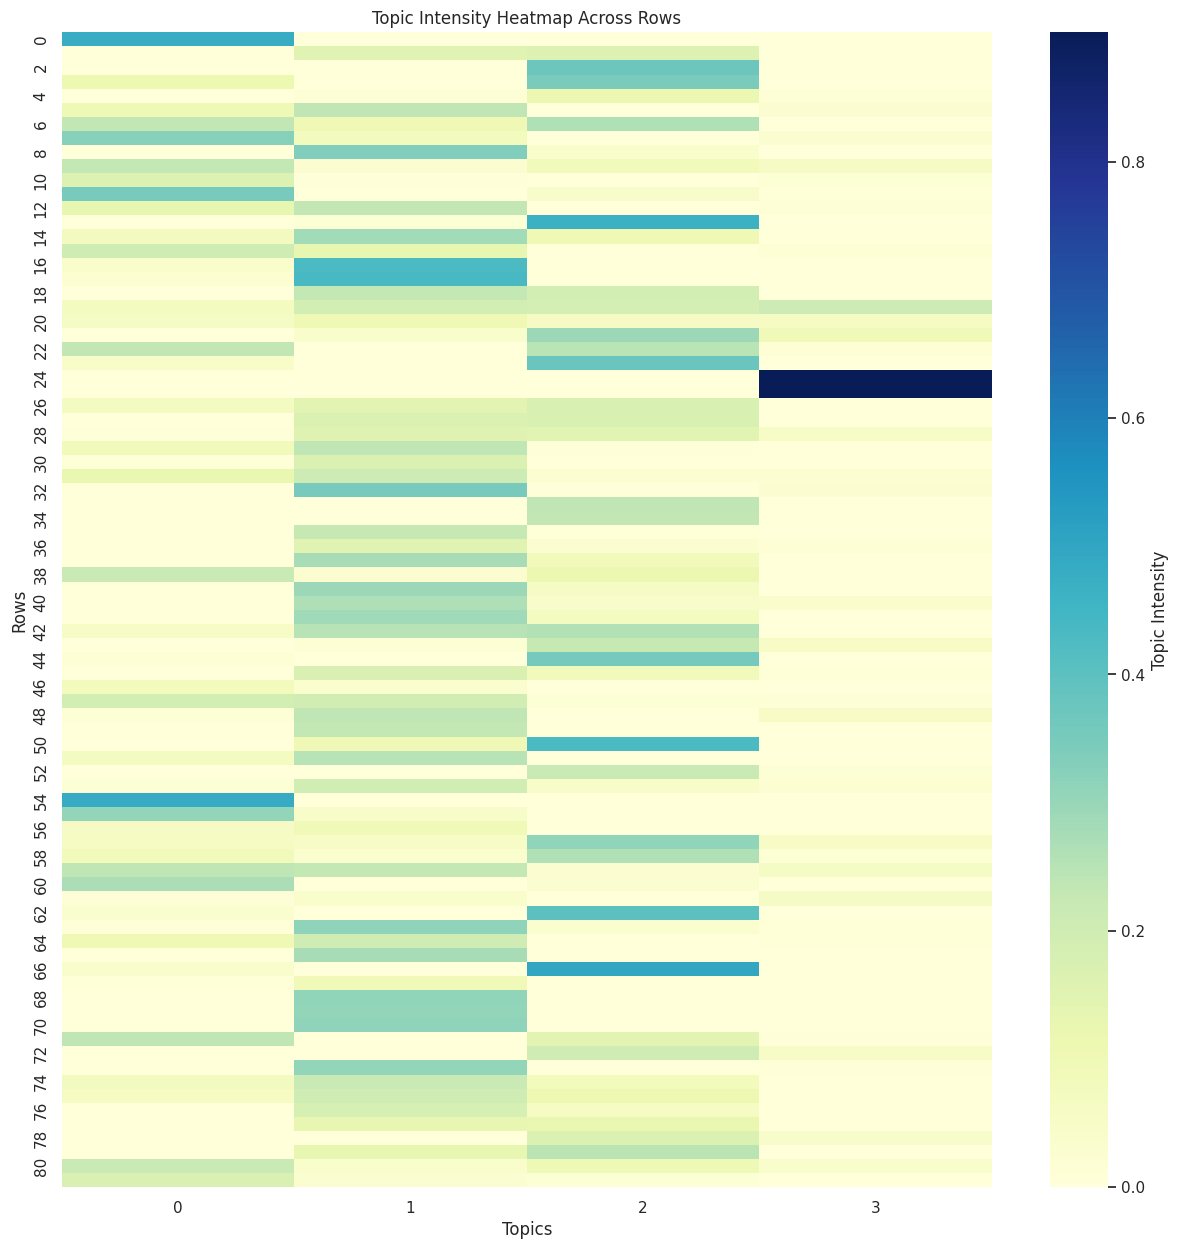

In [97]:
heatmap_data = nmf_topic_matrix
plt.figure(figsize=(15, 15))
sns.heatmap(heatmap_data, cmap='YlGnBu', cbar_kws={'label': 'Topic Intensity'})
plt.title('Topic Intensity Heatmap Across Rows')
plt.xlabel('Topics')
plt.ylabel('Rows')
plt.show()

In [99]:
# def plot_top_words_per_row_horizontal(model, vectorizer, data, title, n_words=10):
#     fig, axes = plt.subplots(1, min(n_rows, 8), figsize=(30, 15))
#     if n_rows == 1:
#         axes = [axes]
#     axes = axes.flatten()

#     for row_idx, ax in enumerate(axes):
#         tfidf_row = vectorizer.transform([data.iloc[row_idx]])
#         feature_weights = tfidf_row.toarray()[0]

#         # Get only top 10 features
#         top_features_ind = feature_weights.argsort()[-n_words:][::-1]
#         top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_ind]
#         weights = feature_weights[top_features_ind]

#         ax.barh(top_features, weights, height=0.7, color='skyblue')
#         ax.set_title(f'Company {row_idx + 1}', fontdict={'fontsize': 20})
#         ax.invert_yaxis()
#         ax.tick_params(axis='both', which='major', labelsize=15)
#         for i in 'top right left'.split():
#             ax.spines[i].set_visible(False)
#     fig.suptitle(title, fontsize=30)
#     plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
#     plt.show()


# plot_top_words_per_row_horizontal(nmf_model, tfidf_vectorizer, df['Processed_Text'], 'Top words per company using NMF')


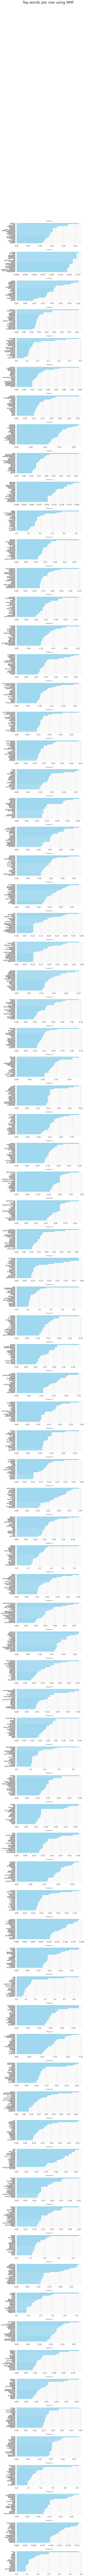

In [100]:
def plot_top_words_per_row_horizontal(model, vectorizer, data, n_words, title):
    n_rows = data.shape[0]
    fig, axes = plt.subplots(min(n_rows, 82), 1, figsize=(10, 4*n_rows))
    if n_rows == 1:
        axes = [axes]
    axes = axes.flatten()

    for row_idx, ax in enumerate(axes):
        tfidf_row = vectorizer.transform([data.iloc[row_idx]])
        feature_weights = tfidf_row.toarray()[0]

        top_features_ind = feature_weights.argsort()[:-n_words - 1:-1]
        top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_ind]
        weights = feature_weights[top_features_ind]

        ax.barh(top_features, weights, height=0.9, color='skyblue')
        ax.set_title(f'Company {row_idx + 1}', fontdict={'fontsize': 10})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=15)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=30)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


plot_top_words_per_row_horizontal(nmf_model, tfidf_vectorizer, df['Processed_Text'], top_n_words, 'Top words per row using NMF')



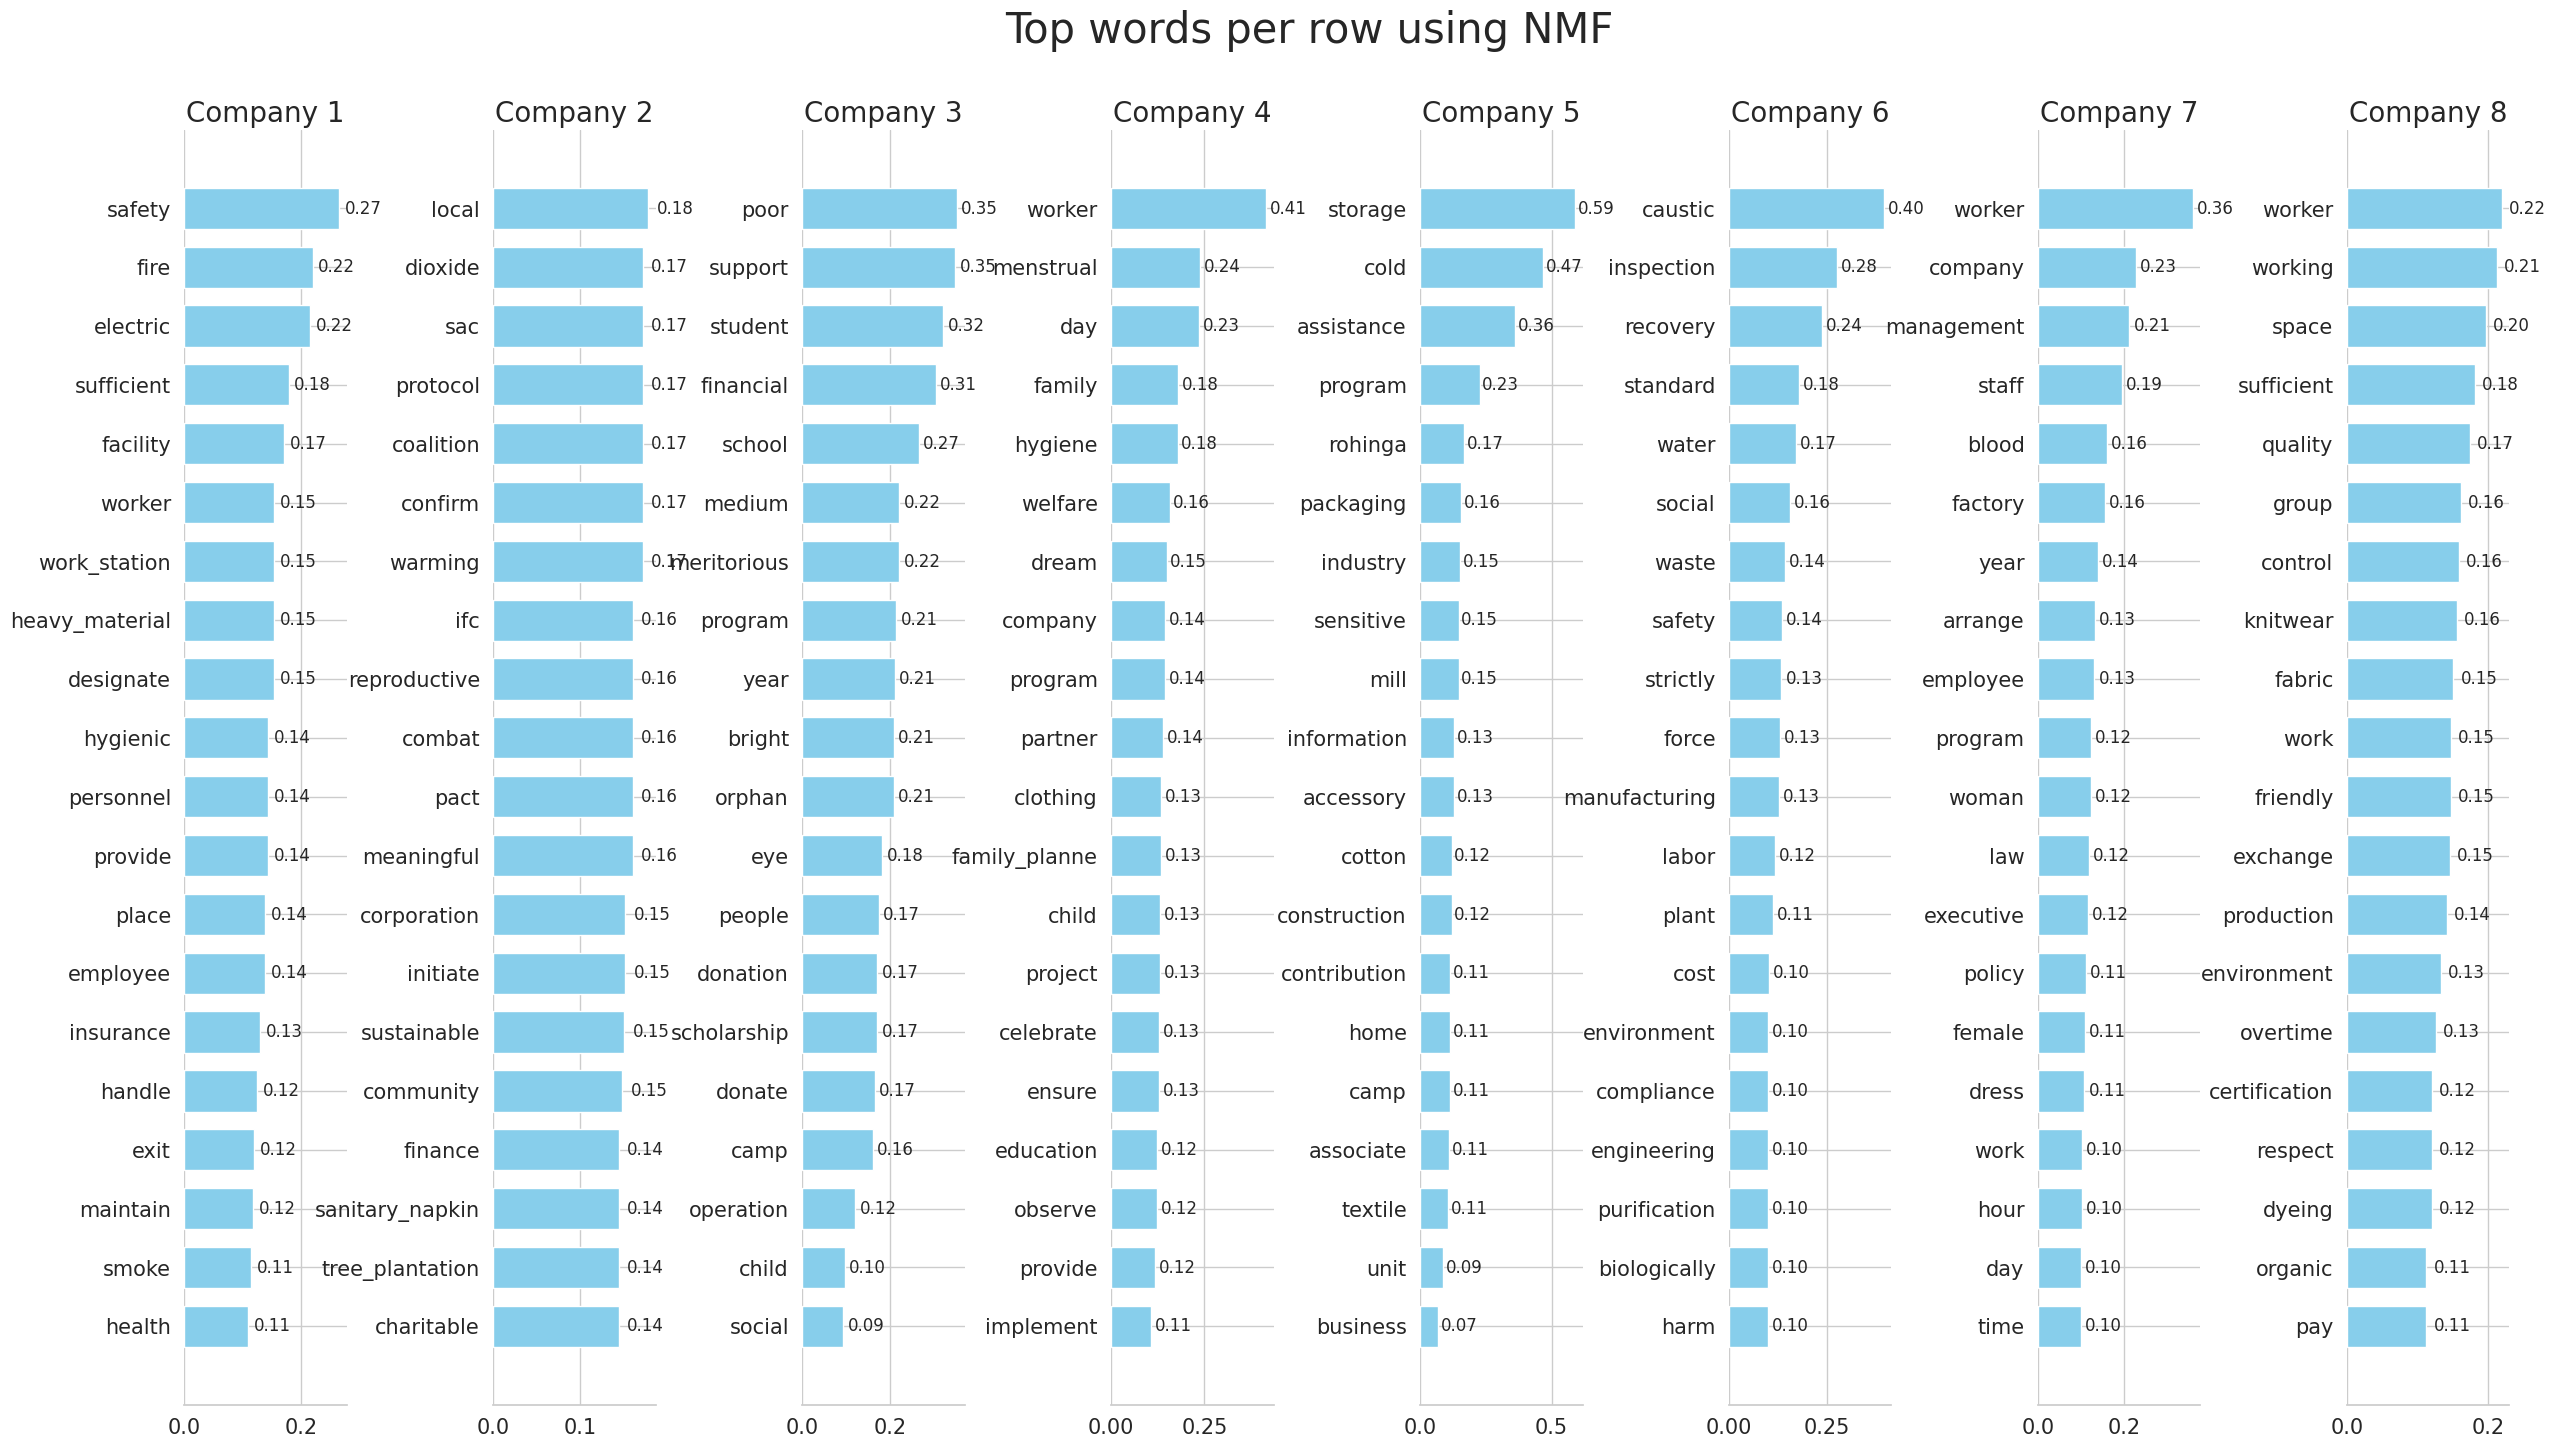

In [101]:
def plot_top_words_per_row_horizontal(model, vectorizer, data, n_words, title):
    n_rows = data.shape[0]
    fig, axes = plt.subplots(1, min(n_rows, 8), figsize=(30, 15))
    if n_rows == 1:
        axes = [axes]
    axes = axes.flatten()

    for row_idx, ax in enumerate(axes):
        tfidf_row = vectorizer.transform([data.iloc[row_idx]])
        feature_weights = tfidf_row.toarray()[0]

        top_features_ind = feature_weights.argsort()[:-n_words - 1:-1]
        top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_ind]
        weights = feature_weights[top_features_ind]

        ax.barh(top_features, weights, height=0.7, color='skyblue')
        ax.set_title(f'Company {row_idx + 1}', fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=15)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)


        for i, v in enumerate(weights):
            ax.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=12)

    fig.suptitle(title, fontsize=30)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
plot_top_words_per_row_horizontal(nmf_model, tfidf_vectorizer, df['Processed_Text'], top_n_words, 'Top words per row using NMF')

In [102]:
def print_top_words_per_company(vectorizer, data, n_words=15):
    n_companies = data.shape[0]

    for company_idx in range(n_companies):
        tfidf_row = vectorizer.transform([data.iloc[company_idx]])
        feature_weights = tfidf_row.toarray()[0]
        top_features_ind = feature_weights.argsort()[-n_words:][::-1]
        top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_ind]

        print(f"Company {company_idx + 1} Top {n_words} words:")
        print(", ".join(top_features))
        print("\n")


print_top_words_per_company(tfidf_vectorizer, df['Processed_Text'])


Company 1 Top 15 words:
safety, fire, electric, sufficient, facility, worker, work_station, heavy_material, designate, hygienic, personnel, provide, place, employee, insurance


Company 2 Top 15 words:
local, dioxide, sac, protocol, coalition, confirm, warming, ifc, reproductive, combat, pact, meaningful, corporation, initiate, sustainable


Company 3 Top 15 words:
poor, support, student, financial, school, medium, meritorious, program, year, bright, orphan, eye, people, donation, scholarship


Company 4 Top 15 words:
worker, menstrual, day, family, hygiene, welfare, dream, company, program, partner, clothing, family_planne, child, project, celebrate


Company 5 Top 15 words:
storage, cold, assistance, program, rohinga, packaging, industry, sensitive, mill, information, accessory, cotton, construction, contribution, home


Company 6 Top 15 words:
caustic, inspection, recovery, standard, water, social, waste, safety, strictly, force, manufacturing, labor, plant, cost, environment


Comp

In [103]:
import pandas as pd


# Export the DataFrame to an Excel file
excel_filename = '/content/nmf_topic_matrix_with_companies.xlsx'
nmf_topic_matrix_df.to_excel(excel_filename, index=False)

print(f'The NMF topic matrix DataFrame has been saved to {excel_filename}')


The NMF topic matrix DataFrame has been saved to /content/nmf_topic_matrix_with_companies.xlsx


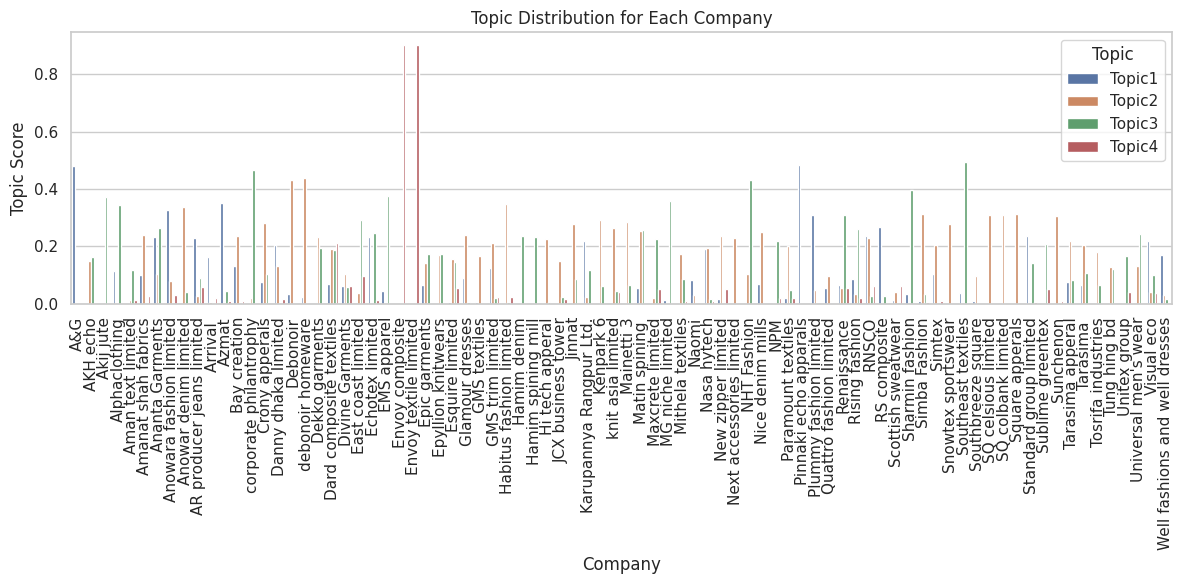

In [104]:
sns.set(style="whitegrid")

# Preparing the data for visualization
visualization_df = nmf_topic_matrix_df.melt(id_vars=['Company', 'Dominant_Topic'],
                                            var_name='Topic',
                                            value_name='Score')

visualization_df = visualization_df[visualization_df['Topic'] != 'Dominant_Topic']

# Creating a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Company', y='Score', hue='Topic', data=visualization_df)
plt.xticks(rotation=90)
plt.title('Topic Distribution for Each Company')
plt.xlabel('Company')
plt.ylabel('Topic Score')
plt.tight_layout()
plt.show()

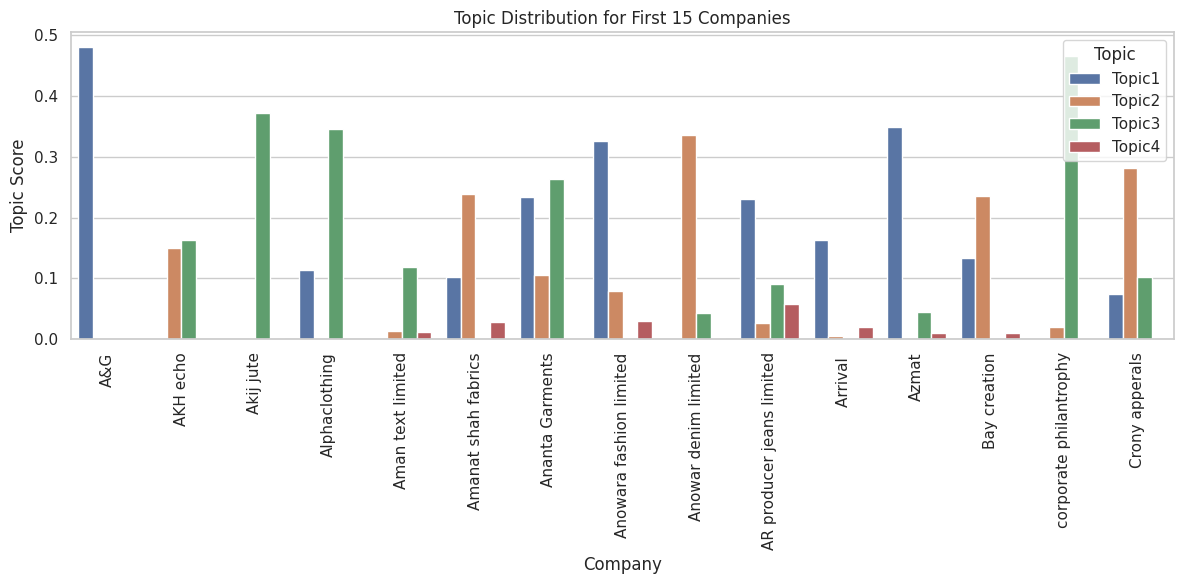

In [105]:
# Selecting the first 15 companies from the visualization DataFrame
visualization_df_subset = visualization_df[visualization_df['Company'].isin(nmf_topic_matrix_df['Company'][:15])]

# Creating a bar plot for the subset
plt.figure(figsize=(12, 6))
sns.barplot(x='Company', y='Score', hue='Topic', data=visualization_df_subset)
plt.xticks(rotation=90)
plt.title('Topic Distribution for First 15 Companies')
plt.xlabel('Company')
plt.ylabel('Topic Score')
plt.tight_layout()
plt.show()


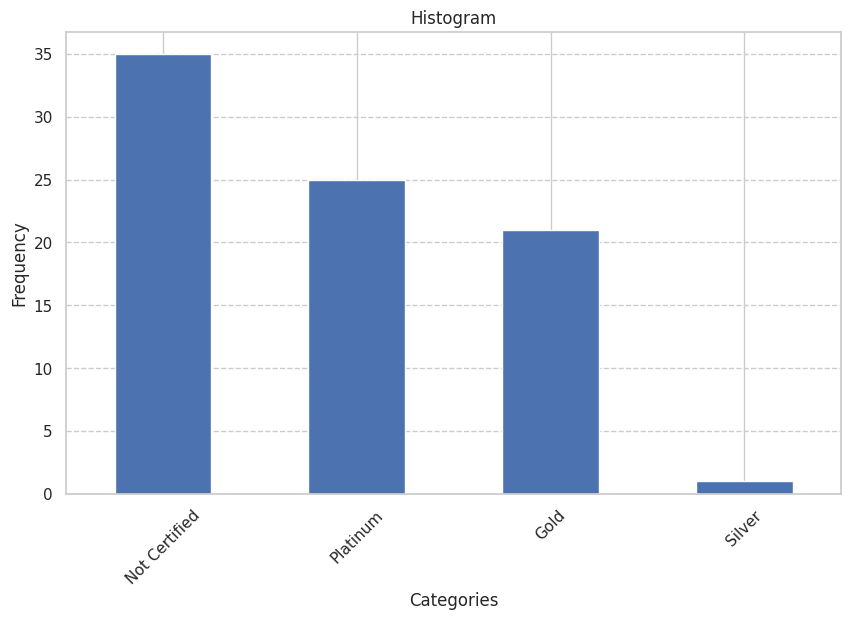

In [106]:
# Count the occurrences of each unique label
label_counts = df['CertLevel'].value_counts(dropna=False)

# Plotting
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Histogram')
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()
